In [1]:
import numpy as np
import ampligraph

In [2]:
from ampligraph.datasets import load_wn18rr

dataset = load_wn18rr(clean_unseen=True)

train_raw = dataset["train"]
dev_raw = dataset["valid"]
test_raw  = dataset["test"]

everything = np.concatenate((train_raw, dev_raw, test_raw))

print(f"train size: {train_raw.shape}")
print(f"dev size: {dev_raw.shape}")
print(f"test size: {test_raw.shape}")
print(f"everything: {everything.shape}")

train size: (86835, 3)
dev size: (2824, 3)
test size: (2924, 3)
everything: (92583, 3)


In [3]:
from ampligraph import datasets

fb15k_237_raw = datasets.load_fb15k_237()
print(fb15k_237_raw["train"][0])

wn18rr_raw = datasets.load_wn18rr()
print(wn18rr_raw["train"][0])

yago3_10_raw = datasets.load_yago3_10()
print(yago3_10_raw["train"][10])

wn11_raw = datasets.load_wn11()
print(wn11_raw["train"][0])

fb13_raw = datasets.load_fb13()
print(fb13_raw["train"][0])

['/m/027rn' '/location/country/form_of_government' '/m/06cx9']
['00260881' '_hypernym' '00260622']
['Peter_Creamer' 'wasBornIn' 'Hartlepool']
['__spiritual_bouquet_1' '_type_of' '__sympathy_card_1']
['antoine_brutus_menier' 'religion' 'roman_catholic_church']


In [13]:
def find_majority_acc(rawdata):
    dev = rawdata["valid"]
    rels_raw = np.unique(dev[:, 1])
    rel2idx = { rel: k for k, rel in enumerate(rels_raw) }
    dev_rels = np.vectorize(lambda rel: rel2idx[rel])(dev[:, 1])
    max_rel_idx = np.bincount(dev_rels).argmax()
    return (dev_rels == max_rel_idx).mean()

for d in ( fb15k_237_raw, wn18rr_raw, yago3_10_raw, wn11_raw, fb13_raw):
    print(find_majority_acc(d))

0.07006732854045418
0.3810198300283286
0.3388911209321012
0.319868771785934
0.27708192281652


In [114]:
def fancysplit(s):
    spans = []
    start = 0
    for k, ch in enumerate(s):
        if ch.isupper():
            spans.append((start, k))
            start = k
    spans.append((start, len(s)))
        
    return [ s[start:end] for start, end in spans ]

fancysplit("Hello")

['', 'Hello']

In [9]:
entities = np.unique(np.concatenate([everything[:, 0], everything[:, 2]]))
num_entities = len(entities)
print(f"{num_entities} entities")

40559 entities


In [10]:
relations = np.unique(everything[:, 1])
num_relations = len(relations)
print(f"{num_relations} relations")

11 relations


In [11]:
idx2ent = np.copy(entities)
ent2idx = { ent: k for k, ent in enumerate(idx2ent) }

idx2rel = np.copy(relations)
rel2idx = { rel: k for k, rel in enumerate(idx2rel) }

In [86]:
def convert(raw, ent2idx, rel2idx):
    ent_lookup = np.vectorize(lambda ent: ent2idx[ent])
    rel_lookup = np.vectorize(lambda rel: rel2idx[rel])
    
    sbjs = ent_lookup(raw[:, 0])
    objs = ent_lookup(raw[:, 2])
    rels = rel_lookup(raw[:, 1])
        
    return (sbjs, objs, rels)

train_sbjs, train_objs, train_rels = convert(train_raw, ent2idx, rel2idx)
dev_sbjs,   dev_objs,   dev_rels   = convert(dev_raw,   ent2idx, rel2idx)
test_sbjs,  test_objs,  test_rels  = convert(test_raw,  ent2idx, rel2idx)

In [90]:
max_rel_idx = np.bincount(dev_rels).argmax()
(dev_rels == max_rel_idx).mean()

0.3810198300283286

In [91]:
import torch

print(torch.cuda.is_available())

True


In [92]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [93]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, sbjs, objs, rels):
        self.sbjs = torch.tensor(sbjs).to(int)
        self.objs = torch.tensor(objs).to(int)
        self.rels = torch.tensor(rels).to(int)
        assert self.sbjs.shape == self.objs.shape
        assert self.sbjs.shape == self.rels.shape
        
    def __len__(self):
        return len(self.sbjs)
    
    def __getitem__(self, k):
        return ( self.sbjs[k], self.objs[k], self.rels[k] )

In [94]:
train_set = MyDataset(train_sbjs, train_objs, train_rels)
dev_set   = MyDataset(dev_sbjs,   dev_objs,   dev_rels)
test_set  = MyDataset(test_sbjs,  test_objs,  test_rels)

In [95]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
dev_loader   = DataLoader(dev_set,   batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

In [107]:
import torch.nn as nn
from torch.distributions.normal import Normal
import sys

class NormalEmbs(nn.Module):
    def __init__(self, num_entities, emb_dim, mean, var):
        super(NormalEmbs, self).__init__()
        
        n = Normal(mean, var)
        weights = n.sample(num_entities, emb_dim)
        self.embs = nn.Embedding.from_pretrained(weights, freeze=False)
        
    def forward(self, ents):
        return self.embs(ents)
    
class GloveEmbs(nn.Module):
    def __init__(self, weights_path):
        with open(weights_path, "rb") as f:
            weights = np.load(f)
            
        self.embs = nn.Embedding.from_pretrained(weights, freeze=False)
    
    def precomp(self, idx2ent, glove_path, weights_path, delim=None):
        num_ents = len(idx2ent)
        
        word2vec = dict()
        with open(glove_path, "r") as f:
            for line in f:
                things = line.split()
                word = things[0]
                vec = np.array(list(map(float, things[1:])))
                word2vec[word] = vec
                
        hits = 0
        misses = 0
                  
        weights = np.zeros((num_ents, 300))
        for idx, ent in idx2ent.items():
            weight = []
            for word in ent.split(delim):
                word = word.lower()
                weight.append(word2vec[word] if word in word2vec else np.zeros((300,)))
                hits += word in word2vec
                misses += word not in word2vec
            weights[idx] = np.mean(mean, axis=0)
                  
        print(f"{hits}/{hits + misses} hits ({float(hits) * 10000 // float(hits + misses) / 100}%)")
            
        with open(weights_path, "wb+") as f:
            np.save(f, weights)

    def forward(self, ents):
        return self.embs(ents)
            
class Bilinear(nn.Module):
    def __init__(self, emb_dim, num_relations):
        super(Bilinear, self).__init__()
        
        self.bilinear = nn.Bilinear(emb_dim, emb_dim, num_relations)
        
    def forward(self, sbjs, objs):
        return self.bilinear(sbjs, objs)

In [97]:
import torch.optim as optim

emb_dim = 300

model = Bilinear(num_entities, emb_dim, num_relations)
model.to(device)

optim = optim.Adam(model.parameters())

In [98]:
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm import tqdm

training_metrics = []

model.train()
for epoch in range(10):
    model.train()
    
    train_batch_losses = []
    train_batch_preds = []
    train_batch_rels = []
    
    print("Training...")
    
    for train_batch in tqdm(train_loader):
        sbjs, objs, rels = train_batch

        sbjs = sbjs.to(device)
        objs = objs.to(device)
        rels = rels.to(device)

        logits = model(sbjs, objs)
        loss = F.cross_entropy(logits, rels, reduction="none")
        preds = F.softmax(logits, dim=-1).argmax(dim=-1) 

        loss.sum().backward()
        
        train_batch_losses.append(loss.cpu())
        train_batch_preds.append(preds.cpu())
        train_batch_rels.append(rels.cpu())

        optim.step()
        
    train_loss = float(torch.cat(train_batch_losses).mean())
    train_preds = torch.cat(train_batch_preds)
    train_rels = torch.cat(train_batch_rels)
    
    train_acc = float((train_preds == train_rels).to(float).mean())
    train_f1 = f1_score(train_rels, train_preds, average="macro")
    
    model.eval()
    
    dev_batch_losses = []
    dev_batch_preds = []
    dev_batch_rels = []
    
    print("Validation...")
    
    for dev_batch in tqdm(dev_loader):
        sbjs, objs, rels = dev_batch

        sbjs = sbjs.to(device)
        objs = objs.to(device)
        rels = rels.to(device)

        logits = model(sbjs, objs)
        loss = F.cross_entropy(logits, rels, reduction="none")
        preds = F.softmax(logits, dim=-1).argmax(dim=-1) 
        
        dev_batch_losses.append(loss.cpu())
        dev_batch_preds.append(preds.cpu())
        dev_batch_rels.append(rels.cpu())
        
    dev_loss = float(torch.cat(dev_batch_losses).mean())
    dev_preds = torch.cat(dev_batch_preds)
    dev_rels = torch.cat(dev_batch_rels)
    
    dev_acc = float((dev_preds == dev_rels).to(float).mean())
    dev_f1 = f1_score(dev_rels, dev_preds, average="macro")
    
    print(f"Epoch {epoch+1}/100")
    print(f"\tTraining accuracy: {train_acc},\tF1: {train_f1},\tLoss: {float(train_loss)}")
    print(f"\tValidation accuracy: {dev_acc},\tF1: {dev_f1},\tLoss: {float(dev_loss)}")
    
    training_metrics.append(( epoch, train_acc, train_f1, train_loss, "train" ))
    training_metrics.append(( epoch, dev_acc, dev_f1, dev_loss, "dev" ))

Training...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [00:10<00:00, 133.24it/s]


Validation...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 121.97it/s]


Epoch 1/100
	Training accuracy: 0.343467495825416,	F1: 0.15756633236977613,	Loss: 141.5579376220703
	Validation accuracy: 0.35410764872521244,	F1: 0.18395653196006487,	Loss: 563.873779296875
Training...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [00:10<00:00, 135.47it/s]


Validation...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 156.75it/s]


Epoch 2/100
	Training accuracy: 0.717164737720965,	F1: 0.5056112378360468,	Loss: 765.9420166015625
	Validation accuracy: 0.4978753541076487,	F1: 0.2835737794821599,	Loss: 3074.48583984375
Training...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [00:10<00:00, 129.54it/s]


Validation...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 127.23it/s]


Epoch 3/100
	Training accuracy: 0.8950538377382392,	F1: 0.7205639187740741,	Loss: 758.3543701171875
	Validation accuracy: 0.5371813031161473,	F1: 0.3240067467727563,	Loss: 8802.0380859375
Training...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [00:10<00:00, 133.83it/s]


Validation...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 122.79it/s]


Epoch 4/100
	Training accuracy: 0.9336903322393044,	F1: 0.792373497267164,	Loss: 902.953125
	Validation accuracy: 0.5591359773371105,	F1: 0.34224058796113277,	Loss: 18517.240234375
Training...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [00:07<00:00, 191.81it/s]


Validation...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 122.48it/s]


Epoch 5/100
	Training accuracy: 0.9520930500374273,	F1: 0.8349131137119066,	Loss: 1064.1087646484375
	Validation accuracy: 0.5722379603399433,	F1: 0.35188629991614095,	Loss: 33631.45703125
Training...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [00:10<00:00, 130.71it/s]


Validation...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 117.28it/s]


Epoch 6/100
	Training accuracy: 0.9619853745609489,	F1: 0.858467685988095,	Loss: 1240.391845703125
	Validation accuracy: 0.5796742209631728,	F1: 0.3525331908526214,	Loss: 54385.5234375
Training...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [00:10<00:00, 129.38it/s]


Validation...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 162.72it/s]


Epoch 7/100
	Training accuracy: 0.9674440029941844,	F1: 0.8771442719274234,	Loss: 1455.631103515625
	Validation accuracy: 0.5803824362606232,	F1: 0.35762129783248703,	Loss: 82636.28125
Training...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [00:10<00:00, 131.57it/s]


Validation...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 126.42it/s]


Epoch 8/100
	Training accuracy: 0.9714516036160534,	F1: 0.8845814351893875,	Loss: 1729.3177490234375
	Validation accuracy: 0.5817988668555241,	F1: 0.3581378229252246,	Loss: 119320.40625
Training...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [00:10<00:00, 133.61it/s]


Validation...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 123.70it/s]


Epoch 9/100
	Training accuracy: 0.9752864628318074,	F1: 0.8957261749301085,	Loss: 1908.295654296875
	Validation accuracy: 0.5871104815864022,	F1: 0.3557073931073188,	Loss: 165464.9375
Training...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1357/1357 [00:10<00:00, 131.42it/s]


Validation...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 124.70it/s]

Epoch 10/100
	Training accuracy: 0.977106005642886,	F1: 0.9093518281263449,	Loss: 2179.490478515625
	Validation accuracy: 0.5938385269121813,	F1: 0.36598652591903547,	Loss: 220611.109375


In [99]:
import seaborn as sns
import pandas as pd

sns.set_theme()
df = pd.DataFrame.from_records(training_metrics, columns=( "epoch", "acc", "f1", "loss", "set" ))

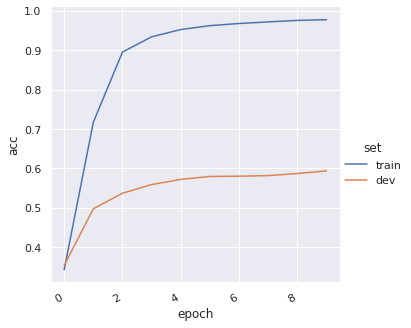

In [100]:
g = sns.relplot(x="epoch", y="acc", hue="set", ci=None, kind="line", data=df)
g.figure.autofmt_xdate()

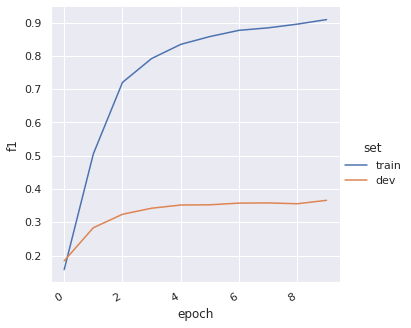

In [101]:
g = sns.relplot(x="epoch", y="f1", hue="set", ci=None, kind="line", data=df)
g.figure.autofmt_xdate()

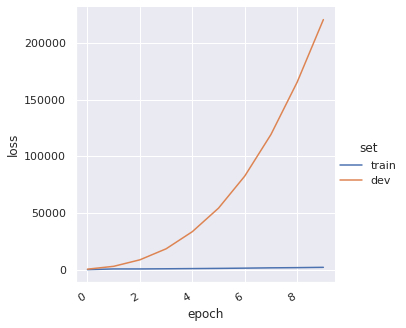

In [102]:
g = sns.relplot(x="epoch", y="loss", hue="set", ci=None, kind="line", data=df)
g.figure.autofmt_xdate()

In [103]:
model.eval()

with torch.no_grad():
    test_batch_losses = []
    test_batch_preds = []
    test_batch_rels = []
    
    print("Testing...")
    
    for test_batch in tqdm(test_loader):
        sbjs, objs, rels = test_batch

        sbjs = sbjs.to(device)
        objs = objs.to(device)
        rels = rels.to(device)

        logits = model(sbjs, objs)
        loss = F.cross_entropy(logits, rels, reduction="none")
        preds = F.softmax(logits, dim=-1).argmax(dim=-1) 
        
        test_batch_losses.append(loss.cpu())
        test_batch_preds.append(preds.cpu())
        test_batch_rels.append(rels.cpu())
        
    test_loss = torch.cat(test_batch_losses).mean()
    test_preds = torch.cat(test_batch_preds)
    test_rels = torch.cat(test_batch_rels)
    
    test_acc = (test_preds == test_rels).to(float).mean()
    test_f1 = f1_score(test_rels, test_preds, average="macro")
    
    print(f"\tTest accuracy: {test_acc},\tF1: {test_f1},\tLoss: {float(test_loss)}")

Testing...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 142.95it/s]

	Test accuracy: 0.5896032831737346,	F1: 0.3718244884101367,	Loss: 221394.6875


In [ ]:
def setup(rawdata, delim, num_epochs):
    train_raw = rawdata["train"]
    dev_raw   = rawdata["valid"]
    test_raw  = rawdata["test"]

    everything = np.concatenate((train_raw, dev_raw, test_raw))
    
    entities = np.unique(np.concatenate([everything[:, 0], everything[:, 2]]))
    num_entities = len(entities)

    relations = np.unique(everything[:, 1])
    num_relations = len(relations)

    idx2ent = np.copy(entities)
    ent2idx = { ent: k for k, ent in enumerate(idx2ent) }

    idx2rel = np.copy(relations)
    rel2idx = { rel: k for k, rel in enumerate(idx2rel) }

    train_sbjs, train_objs, train_rels = convert(train_raw, ent2idx, rel2idx)
    dev_sbjs,   dev_objs,   dev_rels   = convert(dev_raw,   ent2idx, rel2idx)
    test_sbjs,  test_objs,  test_rels  = convert(test_raw,  ent2idx, rel2idx)
    
    train_set = MyDataset(train_sbjs, train_objs, train_rels)
    dev_set   = MyDataset(dev_sbjs,   dev_objs,   dev_rels)
    test_set  = MyDataset(test_sbjs,  test_objs,  test_rels)